In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error

## Linear Approximation

In [2]:
def approxLinear(X, Y):
  return np.linalg.lstsq(X, Y, rcond=None)[0].T

## Nonlinear Approximation (with Radial Basis Functions)

In [3]:
def radialFunction(center, X, eps):
  return np.exp(-euclidean_distances(X, [center]) ** 2 / eps ** 2)

In [4]:
def radialBase(num_basis, X):
  centers = np.random.RandomState(seed=42).permutation(len(X))[:num_basis]
  return X[centers]

In [5]:
def radialBasis(base, X, eps):
  test = []
  for center in base:
    test.append(radialFunction(center, X, eps))
  test = np.asarray(test)
  return test.T[0]

In [6]:
def approxNonLinear(X, Y, num_basis, eps):
  
  base = radialBase(num_basis, X)
  radial_functions = radialBasis(base, X, eps)

  return np.linalg.lstsq(radial_functions, Y, rcond=None)[0].T, base

In [39]:
def findNumCenters(x0, x1):
  # Tune the number of centers
  search = np.linspace(100, 1000, 50)[:-1]
  search = np.concatenate((search,[1000]))
  eps = 2
  best = 0.1, np.inf, None, None
  for center_num in search:
    coeff, base = approxNonLinear(x0, vec, int(center_num), eps)
    err = mse(x1, x0 + radialBasis(base, x0, eps) @ coeff.T * 0.1)

    if err < best[1]:
      best = int(center_num), err, coeff, base
  
  return best

## Read data

In [7]:
def loadVecData(file_x0, file_x1):
  x0 = open(f'{file_x0}.txt', 'r')
  x1 = open(f'{file_x1}.txt', 'r')

  x0_data = np.loadtxt(x0)
  x1_data = np.loadtxt(x1)

  x0.close()
  x1.close()
  return x0_data, x1_data

## Generate difference vector (for the estimation)

In [8]:
def generateVector(x0, x1, timestep):
  return (x1 - x0) / timestep 

## Calculate MSE

In [9]:
def mse(real_data, predicted_data):
  return np.linalg.norm(real_data - predicted_data) ** 2 / len(real_data)

## Callables for the equations to be solved by the solve_ivp (linear and nonlinear)

In [10]:
def stepFunc(t, x0):

    return (x0.reshape(-1,2) @ func.T)

In [30]:
def nonlinStepFunc(t, x0):
    return (radialBasis(best[3], x0, 2) @ best[2].T)

## Part 1: Linear Approximation of the Data

In [11]:
x0, x1 = loadVecData('nonlinear_vectorfield_data_x0', 'nonlinear_vectorfield_data_x1')

In [12]:
vec = generateVector(x0, x1, 0.1)

In [13]:
func = approxLinear(x0, vec)

In [14]:
func

array([[-0.10016012, -0.00253494],
       [ 0.00867272, -0.43267138]])

In [15]:
err = mse(x1, x0 + x0 @ func.T * 0.1)
err

0.037270081174962

In [17]:
x0.shape

(2000, 2)

In [19]:
x1_ = np.ones_like(x0)
for coord in range(x0.shape[0]):
    x1_Est = solve_ivp(stepFunc, (0,1), x0[coord,:], t_eval=[0.1])
    x1_[coord,:] = x1_Est.y[0][0], x1_Est.y[1][0]

In [20]:
err = mse(x1, x1_)
err

0.03727581841318617

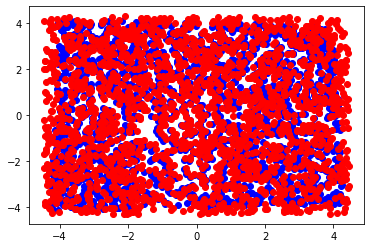

In [21]:
plt.scatter(x1[:,0], x1[:,1], c='b')
plt.scatter(x1_[:,0], x1_[:,1], c='r')
plt.show()

## Part 2: Nonlinear Approximation (Radial Basis functions)

In [26]:
best = findNumCenters(x0, x1)
print("Error = "+str(best[1]))
print("Best number of centers = "+str(best[0]))

Error = 1.420894324561071e-13
Best number of centers = 1000


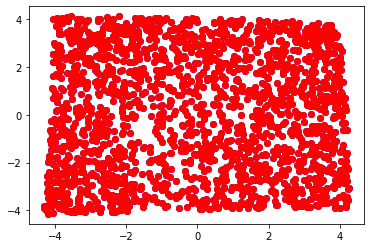

In [27]:
x_1 = x0 + radialBasis(best[3], x0, 2) @ best[2].T * 0.1
plt.scatter(x1[:,0], x1[:,1], c='b')
plt.scatter(x_1[:,0], x_1[:,1], c='r')
plt.show()

## Part 3: Find steady states of the system

In [31]:
# Run the system for 250 time steps
timeSteps = 250
x1_ = np.ones((x0.shape[0], x0.shape[1], timeSteps))
x1_[:,:, 0] = x0

for t in range(1,timeSteps):
    x1_Est =  x1_[:,:, t-1] + nonlinStepFunc(t, x1_[:,:, t-1]) * 0.1
    x1_[:,:, t] = x1_Est

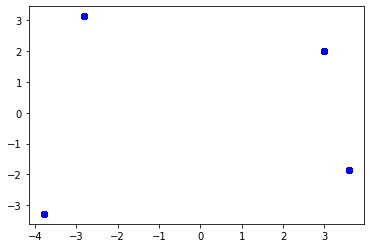

In [32]:
plt.scatter(x1_[:,0,249], x1_[:,1,249], c='b')
plt.show()

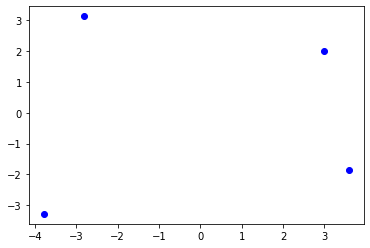

In [35]:
# Save the coordinates of steady states
ss = np.ones((4,2))
k = 0
for sample in x1_[:,:,249]:
    same = False
    for i in range(k):
        if abs(ss[i,0] - sample[0]) < 0.01 :
            same = True
    if not(same):
        ss[k,:] = sample
        k +=1
plt.scatter(ss[:,0], ss[:,1], c='b')

In [37]:
# Run the system for 250 timesteps for the steady state points
timeSteps = 250
x1_ = np.ones((ss.shape[0], ss.shape[1], timeSteps))
x1_[:,:, 0] = ss

for t in range(1,timeSteps):
    x1_Est =  x1_[:,:, t-1] + nonlinStepFunc(t, x1_[:,:, t-1]) * 0.1
    x1_[:,:, t] = x1_Est

In [38]:
# Check if the points change the value at some point 
for sample in range(x1_.shape[0]):
    steady = True
    for t in range(1,x1_.shape[2]):
        if abs(x1_[sample,0,t-1] - x1_[sample,0,t]) > 1e-5 or abs(x1_[sample,1,t-1] - x1_[sample,1,t])> 1e-5:
            steady = False
    if not(steady):
        print(x1_[sample,:,0])
        print("NOT STEADY")